In [1]:
%cd ..

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize': (10, 5)})

c:\app


In [2]:
import pymc as pm
import arviz as az

In [3]:
features = pd.read_csv("./data/features.csv", index_col="Timestamp", parse_dates=["Timestamp"])
features.head()

labels = pd.read_csv("./data/labels.csv", index_col="Timestamp", parse_dates=["Timestamp"])
labels.head()

,LABEL
Timestamp,
2021-01-18 10:00:00,0
2021-01-18 10:30:00,0
2021-01-18 11:00:00,0
2021-01-18 11:30:00,0
2021-01-18 12:00:00,0


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24413 entries, 2021-01-18 10:00:00 to 2022-12-30 22:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   NATR_5   24413 non-null  float64
 1   SMA_500  24413 non-null  float64
dtypes: float64(2)
memory usage: 572.2 KB


**What to do?**

1. X = beta_0 + beta_1 * SMA_10 + beta_2 * RSI_500
2. classification = Sigmoid (x)
3. beta s: Random variables with distributions of N parameters
4. Find the posterior distribution of betas
6. Now found betas -> put in the formula (1,2) and find new data's labels




Text(0, 0.5, 'Probability')

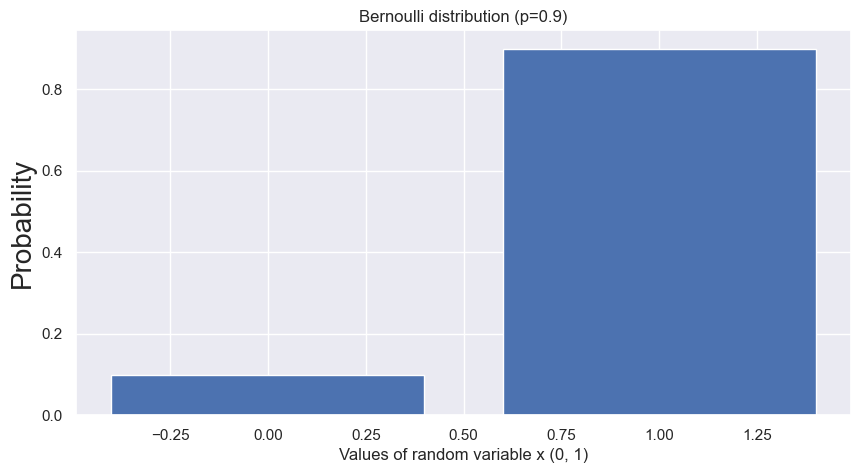

In [5]:
############
# bernoulli
#############
from scipy.stats import bernoulli


# probability of 1 (only two values)
p_1 = 0.9
bd=bernoulli(p_1)

# Outcome of random variable either 0 or 1
x=[0,1]

# For the visualization of the bar plot of Bernoulli's distribution
plt.bar(x, bd.pmf(x))

# For labelling of Bar plot
plt.title(f'Bernoulli distribution (p={p_1})')
plt.xlabel('Values of random variable x (0, 1)')
plt.ylabel('Probability', fontsize='20')

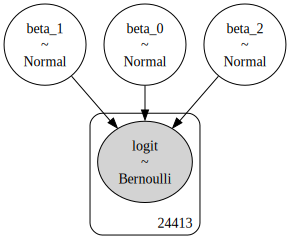

In [6]:
f_cols = features.columns
l_col = labels.columns[0]

with pm.Model() as model:
    # prior
    beta_0 = pm.Normal('beta_0', mu=0, sigma=100)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=100)

    # likelihood - generates values 0 and 1
    likelihood = pm.invlogit(beta_0 + beta_1 * features[f_cols[0]] + beta_2 * features[f_cols[1]])
    
    # if pass on values between 0 and 1 => 
    pm.Bernoulli(name="logit", p = likelihood, observed = labels[l_col])

pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 127 seconds.


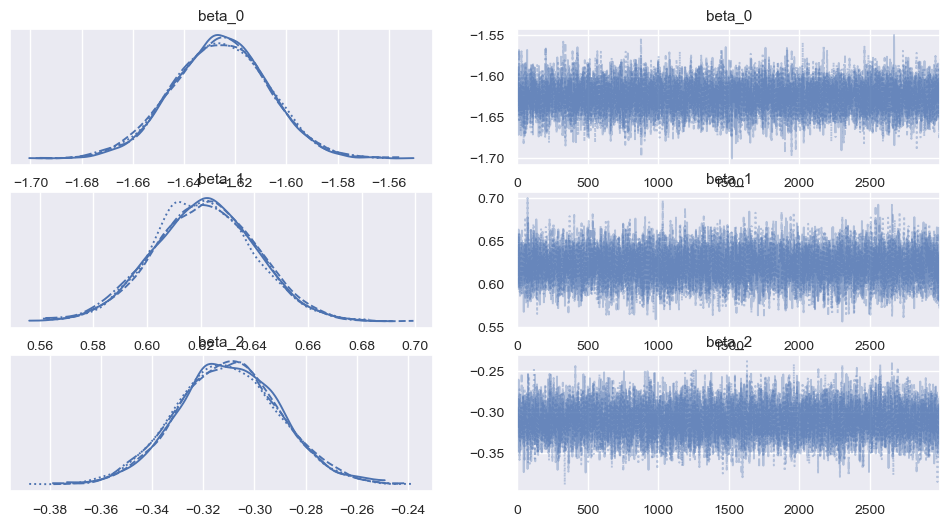

In [7]:
with model:
    trace = pm.sample(3000)
    pm.plot_trace(trace)

In [8]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-1.626,0.019,-1.661,-1.591,0.0,0.0,10698.0,8101.0,1.0
beta_1,0.621,0.019,0.586,0.657,0.0,0.0,8267.0,9005.0,1.0
beta_2,-0.310,0.020,-0.349,-0.274,0.0,0.0,7802.0,8860.0,1.0


array([<Axes: title={'center': 'beta_0'}>,
       <Axes: title={'center': 'beta_1'}>,
       <Axes: title={'center': 'beta_2'}>], dtype=object)

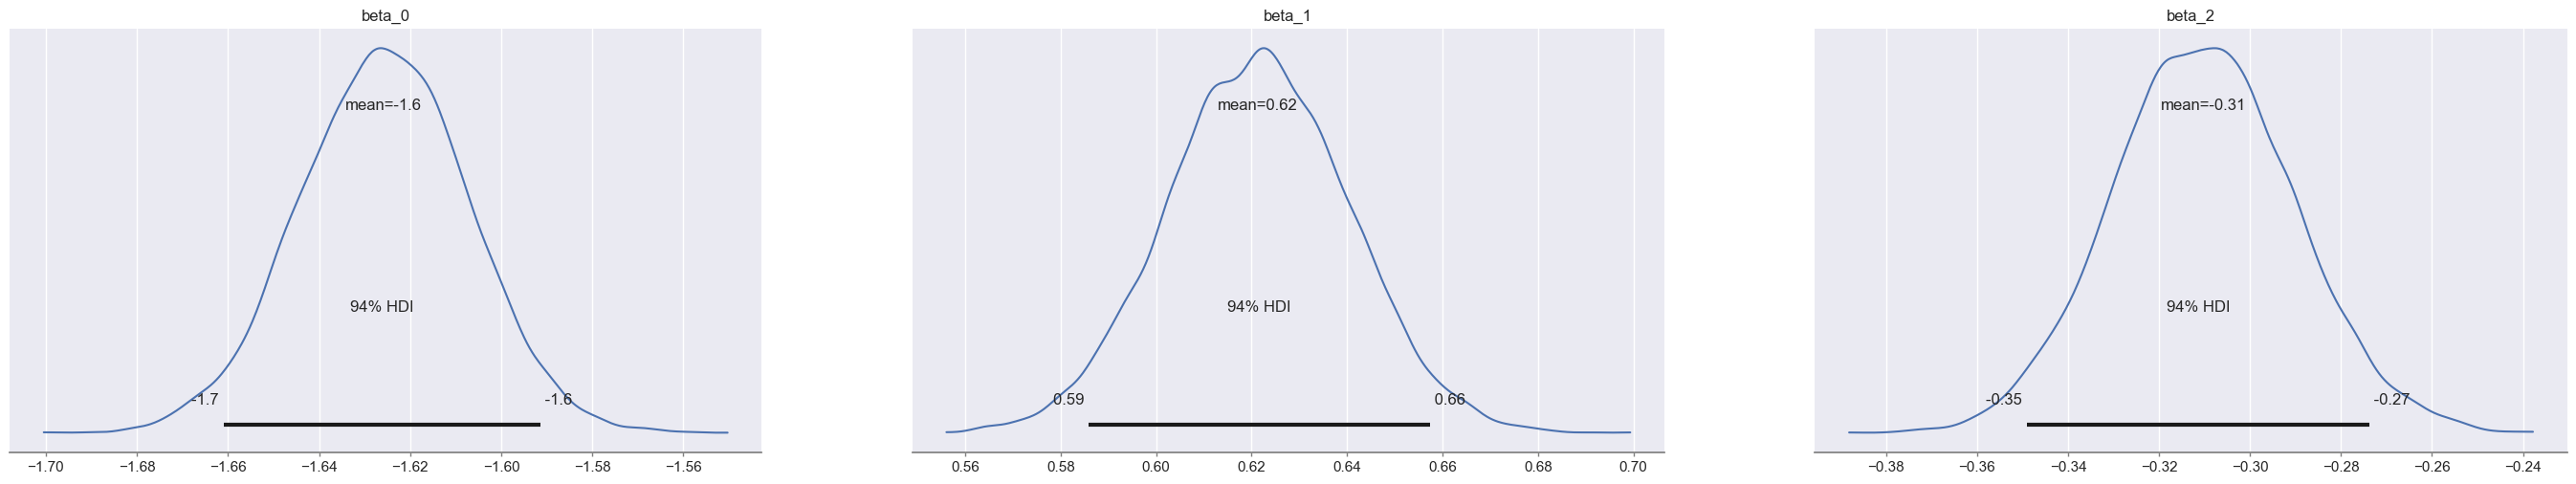

In [9]:
az.plot_posterior(trace)

In [10]:

from scipy.stats import logistic
# so, our prior changed!!!!!
s_beta_0 = -55.98
s_beta_1 = -27.89	
s_beta_2 = -8.44

X = s_beta_0 + s_beta_1 * features[features.columns[0]] + s_beta_2 * features[features.columns[1]]
y_score = logistic.cdf(X)
y_score_df = pd.DataFrame(y_score)

# change 0.2
threshold = y_score.mean()
print(threshold)
y_score_labels = [1 if x > threshold else 0 for x in y_score]


7.546419259311498e-11


<Axes: >

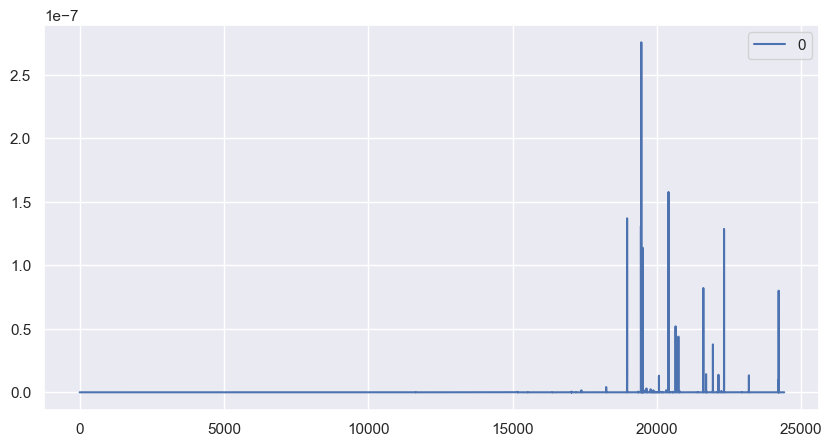

In [11]:

y_score_df.plot()

<Axes: ylabel='Frequency'>

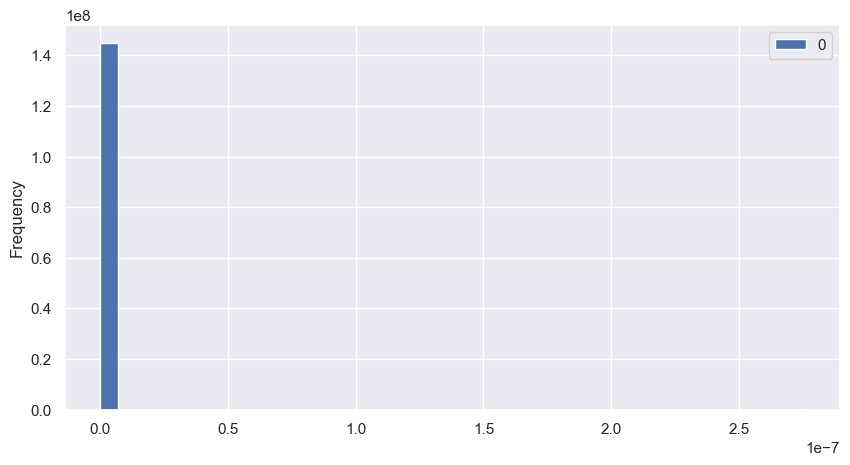

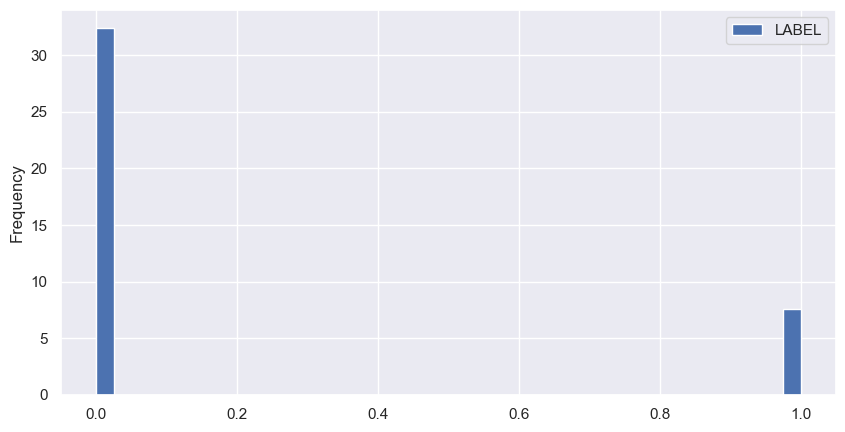

In [12]:
y_score_df.plot.hist(bins=40, density=True)
labels.plot.hist(bins=40, density=True)

In [13]:
import sklearn 
from sklearn.metrics import confusion_matrix

In [14]:
pd.DataFrame(confusion_matrix(labels, y_score_labels).ravel(), index=["tn", "fp", "fn", "tp"]).T

,tn,fp,fn,tp
0,19640,124,4637,12


In [15]:
print(sklearn.metrics.classification_report(labels, y_score_labels))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     19764
           1       0.09      0.00      0.01      4649

    accuracy                           0.80     24413
   macro avg       0.45      0.50      0.45     24413
weighted avg       0.67      0.80      0.72     24413



In [16]:
sample_positive_signal = 226
correct_trades_count = int(sample_positive_signal * 0.39)
wrong_trades_count = int(sample_positive_signal * 0.61)
total_trades = correct_trades_count + wrong_trades_count

print(f"total trades: {total_trades}, correct trades: {correct_trades_count}, wrong trades: {wrong_trades_count}")

total trades: 225, correct trades: 88, wrong trades: 137
